# Neural Network Basics (Part 2)
> Under the hood of a basic Deep Learning Image Classifier (Multi-Class)

- toc: true 
- badges: true
- comments: true
- author: Isaac Flath
- categories: [Computer Vision, Foundations]

In [1]:
from fastai2.vision.all import *
from fastai2.data.external import *
from PIL import Image
import math

# Intro

Today we will be working with the MNIST dataset. The goal is going to be to take an image of handwritten digits and automatically predict what number it is.  We will be building a Neural Network to do this.  This is building off of the Image Classifier Basics post where we classified into 3s and 7s.  If anything in this post is confusing, I reccomend heading over to part 1.  I am assuming that the content covered in Part 1 is understood.

If you get through this and want more detail, I highly recommend checking out Deep Learning for Coders with fastai & Pytorch by Jeremy Howard and Sylvain Gugger. All of the material in this guide and more is covered in much greater detail in that book.

https://www.amazon.com/Deep-Learning-Coders-fastai-PyTorch/dp/1492045527

# Load the Data

Naturally, the first step is to get and load the data.  We'll look at it a bit along tohe way to make sure it was loaded properly as well.  We will be using fastai's built in dataset feature rather than sourcing it ourself.  I am skimming over this quickly as this was covered in part 1.

In [2]:
# This command downloads the MNIST_TINY dataset and returns the path where it was downloaded
path = untar_data(URLs.MNIST)

# This takes that path from above, and get the path for training and validation
training = [x.ls() for x in (path/'training').ls().sorted()]
validation = [x.ls() for x in (path/'testing').ls().sorted()]

Let's take a look at an image.  The first thing I reccomend doing for any dataset is to view something to verify you loaded it right. The second thing is to look at the size of it.  This is not just for memory concerns, but you want to generally know some basics about whatever you are working with. 

In [3]:
# Let's view what one of the images looks like
im3 = Image.open(training[6][1])
im3

In [4]:
# Let's see what shape the underlying matrix is that represents the picture
tensor(im3).shape

torch.Size([28, 28])

# Linear Equation

We are looking to do wx + b = y.   It seems that a Neural network should use some super fancy equation in it's layers, but that's all it is.  In a single class classifier, y has 1 column as it is predicting 1 thing.  In a multiclass classifier y has "however-many-classes-you-have" columns.

### Tensor Setup

The first thing I will do is get my xs and ys in tensors in the right format.

In [5]:
training_t = list()
for x in range(0,len(training)):
    # For each class, stack them together.  Divide by 255 so all numbers are between 0 and 1
    training_t.append(torch.stack([tensor(Image.open(i)) for i in training[x]]).float()/255)
    
validation_t = list()
for x in range(0,len(validation)):
    # For each class, stack them together.  Divide by 255 so all numbers are between 0 and 1
    validation_t.append(torch.stack([tensor(Image.open(i)) for i in validation[x]]).float()/255)

In [6]:
# Let's make sure images are the same size as before (ie we didn't screw anything up)
training_t[1][1].shape

torch.Size([28, 28])

Let's do a simple average of one of our images.  It's a nice sanity check to see that we did things ok.  We can see that after averaging, we get a recognizable number.  That's a good sign.

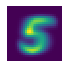

In [7]:
show_image(training_t[5].mean(0))

In [8]:
# combine all our different images into 1 matrix.  Convert Rank 3 tensor to rank 2 tensor.
x = torch.cat([x for x in training_t]).view(-1, 28*28)
valid_x = torch.cat([x for x in validation_t]).view(-1, 28*28)

# Defining Y.  I am starting with a tensor of all 0.  
# This tensor has 1 row per image, and 1 column per class
y = tensor([[0]*len(training_t)]*len(x))
valid_y = tensor([[0]*len(validation_t)]*len(valid_x))

# Column 0 = 1 when the digit is a 0, 0 when the digit is not a 0
# Column 1 = 1 when the digit is a 1, 0 when the digit is not a 1
# Column 2 = 1 when the digit is a 2, 0 when the digit is not a 2
# etc.
j=0
for colnum in range(0,len(training_t)):
    y[j:j+len(training_t[colnum]):,colnum] = 1
    j = j + len(training[colnum])
    
j=0
for colnum in range(0,len(validation_t)):
    valid_y[j:j+len(validation_t[colnum]):,colnum] = 1
    j = j + len(validation[colnum])


# Combine by xs and ys into 1 dataset for convenience.
dset = list(zip(x,y))
valid_dset = list(zip(valid_x,valid_y))

# Inspect the shape of our tensors
x.shape,y.shape,valid_x.shape,valid_y.shape

(torch.Size([60000, 784]),
 torch.Size([60000, 10]),
 torch.Size([10000, 784]),
 torch.Size([10000, 10]))

Perfect.  We have exactly what we need and defined above.  60,000 images x 784 pixels for my x.  A 60,000 images x 10 classes for the predictions.

10,000 images make up the validation set.


### Calculate wx + b
Let's initialize our weights and biases, then do the matrix multiplication and make sure the output is the expected shape (60,000 images x 10 classes).

In [9]:
# Here is how we will initialize paramaters.  This is just giving me random numbers.
def init_params(size, std=1.0): return (torch.randn(size)*std).requires_grad_()

# Initializze w and b weight tensors
w = init_params((28*28,10))
b = init_params(10)

In [10]:
# Lets do our linear equation and see what shape we get.
(x@w+b).shape,(valid_x@w+b).shape

(torch.Size([60000, 10]), torch.Size([10000, 10]))

Great, we have the right number of predictions.  Obviously the predictions are no good.  There a couple things left to do.  The first thing we need to do is turn our Linear Equation into a Neural Network.  To do that we need to do this twice, with a ReLu inbetween.

# Neural Network

>Note: You can check out the first Image Classifier blog post, which explains does this in a simpler problem (single class classifier) and assumes less pre-requisite knowledge.  I am assuming that the information in Part 1 is understood.  If you understand Part 1, you are ready for Part2!

In [11]:
# Here's a simple Neural Network.  
# This can have more layers by duplicating the patten seen below, this is just the fewest layers for demonstration.

def simple_net(xb): 
    
    # Linear Equation from above
    res = xb@w1 + b1 #Linear
    
    # Replace any negative values with 0.  This is called a ReLu.
    res = res.max(tensor(0.0)) #ReLu
    
    # Do another Linear Equation
    res = res@w2 + b2 #Linear
    
    # return the predictions
    return res

In [12]:
# initialize random weights.  
# The number 30 here can be adjusted for more or less model complexity.

multipliers = 30

w1 = init_params((28*28,multipliers))
b1 = init_params(multipliers)
w2 = init_params((multipliers,10))
b2 = init_params(10)

In [13]:
simple_net(x).shape # 60,000 images with 10 predictions per class (one per digit)

torch.Size([60000, 10])

# Improving Weights and Biases

We have predictions with random weights and biases.  What we need to do is to get these weights and biases to be the right numbers rather than random numbers.  To do this we need to use Gradient Descent  to improve the weights.  Here's roughly what we need to do:

+ Create a loss function to measure how close (or far) off we are
+ Calculate the gradient (slope) so we know which direction to step
+ Adjust our values in that direction
+ Repeat many times

The first thing we need to use gradient descent is we need a loss function.  Let's use something simple, how far off we were.  If the correct answer was 1, and we predicted a 0.5 that would be a loss of 0.5.  We will do this for every class

The one addition is that we will add something called a sigmoid.  All a sigmoid is doing is ensuring that all of our predictions land between 0 and 1.  We never want to predict anything outside of these ranges.

>Note: If you want more of a background on what is going on here, please take a look at my series on Gradient Descent where I dive deeper on this.  We will be calculating a gradient - which are equivilant to the "Path Value"

### Loss Function

In [14]:
def mnist_loss(predictions, targets):
    
    # make all prediction between 0 and 1
    predictions = predictions.sigmoid()
    
    # Difference between predictions and target
    return torch.where(targets==1, 1-predictions, predictions).mean()

In [15]:
# Calculate loss on training and validation sets to make sure the function works
mnist_loss(simple_net(x),y),mnist_loss(simple_net(valid_x),valid_y)

(tensor(0.4779, grad_fn=<MeanBackward0>),
 tensor(0.4793, grad_fn=<MeanBackward0>))

### Calculate Gradient

Now we have a function we need to optimize and a loss function to tell us our error.  We are ready for gradient descent.  Let's create a function to change our weights. 

First, we will make sure our datasets are in a DataLoader.  This is convenience class that helps manage our data and get batches.

>Note: This is the same from part 1

In [16]:
# Batch size of 256 - feel free to change that based on your memory
dl = DataLoader(dset, batch_size=1000, shuffle=True)
valid_dl = DataLoader(valid_dset, batch_size=1000)

# Example for how to get the first batch
xb,yb = first(dl)
valid_xb,valid_yb = first(valid_dl)

In [17]:
def calc_grad(xb, yb, model):
    
    # calculate predictions
    preds = model(xb)
    
    # calculate loss
    loss = mnist_loss(preds, yb)
    
    # Adjust weights based on gradients
    loss.backward()

### Train the Model

>Note: This is the same from part 1

In [18]:
def train_epoch(model, lr, params):
    for xb,yb in dl:
        calc_grad(xb, yb, model)
        for p in params:
            p.data -= p.grad*lr
            p.grad.zero_()

### Measure Accuracy on Batch

In [19]:
def batch_accuracy(xb, yb):    
    # this is checking for each row, which column has the highest score.
    # p_inds, y_inds gives the index highest score, which is our prediction.
    p_out, p_inds = torch.max(xb,dim=1)
    y_out, y_inds = torch.max(yb,dim=1)
    
    # Compre predictions with actual
    correct = p_inds == y_inds
    
    # average how often we are right (accuracy)
    return correct.float().mean()

### Measure Accuracy on All

>Note: This is the same from part 1

In [20]:
def validate_epoch(model):
    # Calculate accuracy on the entire validation set
    accs = [batch_accuracy(model(xb), yb) for xb,yb in valid_dl]
    
    # Combine accuracy from each batch and round
    return round(torch.stack(accs).mean().item(), 4)

### Initialize weights and biases

In [21]:
# When classifying 3 vs 7 in part one, we just used 30 weights.  
# With this problem being much harder, I will give it more weights to work with

complexity = 500 
w1 = init_params((28*28,complexity))
b1 = init_params(complexity)
w2 = init_params((complexity,10))
b2 = init_params(10)

params = w1,b1,w2,b2


### Train the Model

Below we will actually train our model.  

In [22]:
lr = 50
# epoch means # of passes through our data (60,000 images)
epochs = 30
loss_old = 9999999

for i in range(epochs):
    train_epoch(simple_net, lr, params)
    
    # Print Accuracy metric every 10 iterations
    if (i % 10 == 0) or (i == epochs - 1):
        print('Accuracy:'+ str(round(validate_epoch(simple_net)*100,2))+'%')
        
    loss_new = mnist_loss(simple_net(x),y)
    
    loss_old = loss_new


Accuracy:22.67%
Accuracy:32.56%
Accuracy:33.12%
Accuracy:34.25%


### Results

A few key points:

+ The Loss is not the same as the metric (Accuracy).  Loss is what the models use, Accuracy is more meaningful to us humans.
+ We see that our loss slowly decreases each epoch.  Our accuracy is getting better over time as well.

We start at about 10% accuracy, which makes sense.  With random weights we predict correctly 1/10 times.  With 10 digits that sounds like a random guess.  Over time, we slowly decrease the loss and after 30 epochs we are around 36% accuracy.  Much better!  We could keep training more to keep improving accuracy, but I think we see the idea.

### This Model vs SOTA

What is different about this model than a best practice model?
+ This model is only 1 layer.  State of the art for image recognitions will use more layers.  Resnet 34 and Resnet 50 are common (34 and 50 layers).  This would just mean we would alternate between the ReLu and linear layers and duplicate what we are doing with more weights and biases.
+ More weights and Biases.  The Weights and Biases I used are fairly small - I ran this extremely quickly on a CPU.  With the appropriate size weight and biases tensors, it would make way more sense to use a GPU.
+ Matrix Multiplication is replaced with Convolutions for image recognition.  A Convolution can be thought of as matrix multiplication if you averaged some of the pixels together.  This intuitively makes sense as 1 pixel in itself is meaningless without the context of other pixels.  So we tie them together some.
+ Dropout would make our model less likely to overfit and less dependent on specific pixels.  It would do this by randomly ignoring different pixels so it cannot rely on them.  It's very similar to how decision trees randomly ignore variables for their splits.
+ Discriminate learning rates means that the learning rates are not the same for all levels of the neural network.  With only 1 layer, naturally we don't worry about this.
+ Gradient Descent - we can adjust our learning rate based on our loss to speed up the process
+ Transfer learning - we can optimize our weights on a similar task so when we start trying to optimize weights on digits we aren't starting from random variables.  
+ Keep training for as many epochs as we see our validation loss decrease


As you can see, these are not completely different models.  These are small tweaks to what we have done above that make improvements - the combination of these small tweaks and a few other tricks are what elevate these models.  There are many 'advanced' variations of Neural Networks, but the concepts are typically along the lines of above.  If you boil them down to what they are really doing without all the jargon - they are pretty simple concepts.  I'll cover them in future blog posts.